# References
## Cleveland et al. (1981)
* Antidromic stimuli applied to study the static behavior of Renshaw cells. Stimulus pulses were 200 $\mu$s wide and supramaximal for $\alpha$-axons.
* Discharge rate was measured during the 5th second after stimulation began at a given frequency.
* The data presented are all averages of a number of such measurements (usually 10) in the same cell.
* The static input-output relations for different frequencies, as shown in their Figure 5A.

## Ross et al. (1982)
* Stimuli consisted of trains of electrical impulses (supramaximal for $\alpha$-axons, 200 $\mu$s wide) applied to the proximal end of cut ventral roots L7 or S1.
* Stimulation were delivered antidromically for 5 s at a given frequency and then suddenly switched to a higher or lower stimulus frequency for another 5 s.
* Step changes recruitment were produced by isolating two filaments from a ventral root, both of which alone sufficed to excite the Renshaw cell. Each part of the root was placed on stimulus electrodes which could be connected by electronic switches to the impulse train, which had a constant frequency (ranging from 5 - 50 Hz) and strength (supramaximal for $\alpha$-axons)

## Uchiyama et al. (2003a)
* Synaptic swellings are indications of the strength of an $\alpha$ motoneuron's synaptic inputs to other spinal neurons. The proportions used are those reported by Cullheim and Kellerth (1978), in which FF number is ca. 1.8 the FR number and ca. 2.2 the S number.

# Parameters adjusted

# Considerations
* Variability is not expected in the model and simulation results supported this. Therefore averages like those described in Cleveland et al. (1981) for each cell will not be carried out and the curve fitting can be done directly from data points obtained in a single simulation.
* Since 5 s is too much to simulate, the adaptation time is reduced and the plot shown is to assure the cell have adapted after the adopted value.
* Figure 5B (Cleveland et al., 1981) can also be a good direction, but I am not expecting too much variation.
* The authors do not report information about population (e.g. distance, type) so I decided to choose random Renshaw cells to take the mean of fitted curves, just like they did.
* For simplicity, stimulations in Ross et al. (1982) were simulated as a antidromic in the whole pool. This is acceptable because of the small topographic distribution of motoneurons and, as argued by the authors, the number of axons collaterals activating the Renshaw cell is not what defines its dynamic behavior.
* In Cleveland et al. (1981) and Ross et al. (1982), deafferentation resulted in no spontaneous responses.
* In Uchiyama et al. (2003a), Figure 7a multiplies number of spikes by 1/(50 ms) when the frequency is 33 Hz and reproduces a result from Ross et al. (1982). Figure 7c multiply number of spikes by the frequency of the steps, and reproduces results from another paper. Therefore, there is a small difference between results described in the literature, but this simulation will consider both in order to have more sources for comparison.

In [1]:
import sys
import time

import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import scipy.optimize

In [2]:
def langmuir(f, c, k):
    return c*f/(k + f)

# Static analysis

In [192]:
tmin = 500
simDuration_ms = 1000
availableRCs = range(1, 601)
recordedRCs = np.random.choice(availableRCs, size=24, replace=False)
print 'Recorded RCs #' + str(recordedRCs)
freqs = [x for x in range(10, 80, 10)]
firingRates = [[0]*len(freqs) for i in range(len(recordedRCs))]
for i, recordedRC in enumerate(recordedRCs):
    for j, freq in enumerate(freqs):
        unitNumber = []
        spikeInstant = []
        filename = 'StaticProperties/'+'output'+str(freq)+'.dat'
        f = open(filename, 'r')
        lines = f.readlines()
        for line in lines:
            spikeInstant.append(float(line.split()[0]))
            unitNumber.append(int(float(line.split()[1])))

    # This to automate
    #     if recordedRC is None:
    #         availableRCs = max(unitNumber)
    #         recordedRC = np.random.choice(availableRCs)
    #         print 'Recorded RC #' + str(recordedRC)

        RCSpikeInstants = [y for x, y in enumerate(spikeInstant) if unitNumber[x]==recordedRC]
        numberOfSpikes = len([x for x in RCSpikeInstants if x>tmin])
        firingRates[i][j] = float(numberOfSpikes)*1e3/(simDuration_ms-tmin)

Recorded RCs #[535 480 383 382  35  87 412 215 120  61 418 442 566 136 243 413 191 411
 562  71 237 301 209 217]


<IPython.core.display.Javascript object>


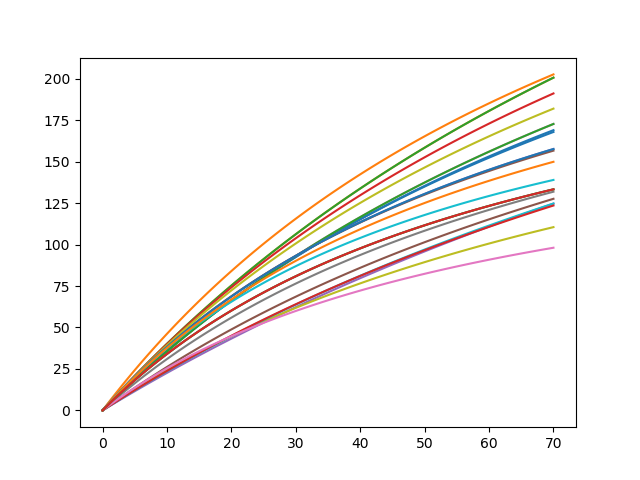

In [193]:
cs = []
plt.figure()
for firingRate in firingRates:
    # Curve fitting
    try:
        # maxfev is passed to least method square and avoids runtime error
        fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, firingRate, bounds=(0, np.inf), maxfev=2000)
        cs.append(fit_params[0])
    except RuntimeError:
        print 'Least square method failed. The value was ignored'
        
    fittedLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)
    plt.plot(np.linspace(0, 70, 100), fittedLangmuir)
plt.show()

<IPython.core.display.Javascript object>


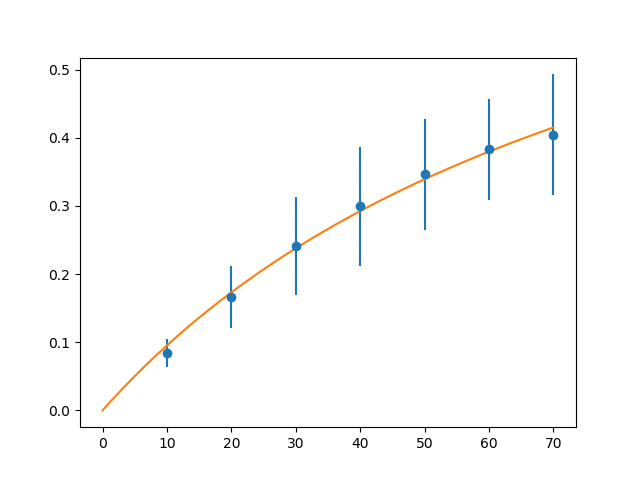

In [194]:
# Langmuir curves averaging
npRates = np.array(firingRates)

# Normalization
for i, c in enumerate(cs):
    npRates[i,:] = npRates[i,:]/c
    
# Statistics
numbCurves = npRates.shape[0]
aveRate = np.sum(npRates, axis=0)/numbCurves
stdRate = np.std(npRates, axis=0)

fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, aveRate, bounds=(0, np.inf), maxfev=2000)
aveLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)

# Plots
plt.figure()
plt.errorbar(freqs, aveRate, stdRate, linestyle='None', marker='o')
plt.plot(np.linspace(0, 70, 100), aveLangmuir)
plt.show()

<IPython.core.display.Javascript object>


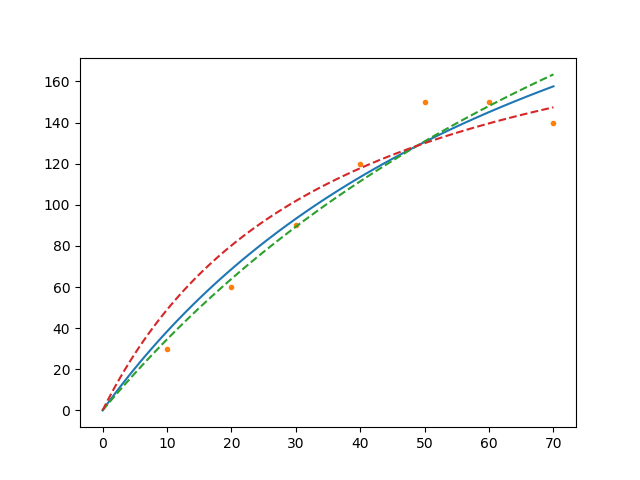

In [195]:
# Checking some RCs
choosenRC = 20
plt.figure()
fit_params, pcov = scipy.optimize.curve_fit(langmuir, freqs, firingRates[choosenRC], bounds=(0, np.inf))
# Standar Errors
SE1 = np.sqrt(np.diag(pcov))[0]
SE2 = np.sqrt(np.diag(pcov))[1]
fittedLangmuir = langmuir(np.linspace(0, 70, 100), *fit_params)
plt.plot(np.linspace(0, 70, 100), fittedLangmuir)
plt.plot(freqs, firingRates[choosenRC], '.')
plt.plot(np.linspace(0, 70, 100), langmuir(np.linspace(0, 70, 100), fit_params[0]+SE1, fit_params[1]+SE2), '--')
plt.plot(np.linspace(0, 70, 100), langmuir(np.linspace(0, 70, 100), fit_params[0]-SE1, fit_params[1]-SE2), '--')
plt.show()

# Dynamic analysis

Recorded RC #10


<IPython.core.display.Javascript object>


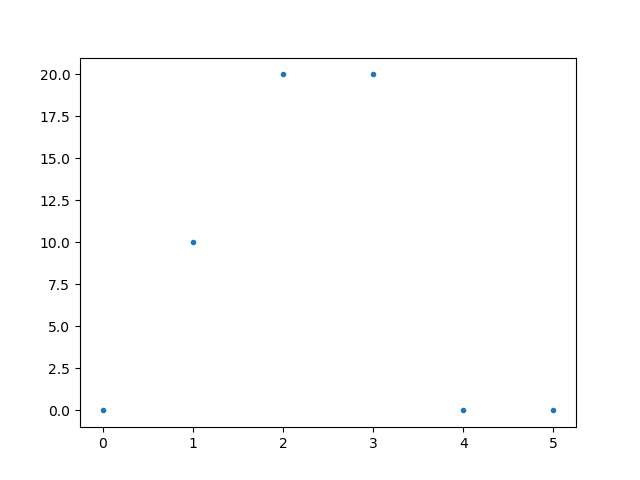

In [7]:
simDuration_ms = 1000
stimPulseDuration = 0.2
timeStep_ms = 0.05
availableRCs = range(300)
frequency1 = 5

recordedRC = 10#np.random.choice(availableRCs)
print 'Recorded RC #' + str(recordedRC)


freqs = [5]#, 15, 28, 45]
for i, freq in enumerate(freqs):
    firingRate = []
    unitNumber = []
    stimulus = []
    spikeInstant = []
    filename = 'dynamic_properties/'+'output'+str(i+1)+'.dat'
    f = open(filename, 'r')
    lines = f.readlines()
    for line in lines:
        spikeInstant.append(float(line.split()[0]))
        unitNumber.append(int(float(line.split()[1])))
    f.close()
    filename = 'dynamic_properties/'+'stimulus'+str(i+1)+'.dat'
    f = open(filename, 'r')
    lines = f.readlines()
    for line in lines:
        stimulus.append(float(line.split()[0]))
    f.close()
    
    # Roughly determines bins, that start after each nonzero value
    stimulusIntervals = np.nonzero(stimulus)[0]
    # How long the stimulus lasts, in indexes
    # +1 is a correction, since in Fortran is was lasting 5
    indexInterval = int(stimPulseDuration/timeStep_ms)+1
    # bins, excluding the ones that do not finish
    numberOfBins = int(len(stimulusIntervals)/indexInterval)
    # Creates one array for each bin
    bins = np.split(stimulusIntervals[:numberOfBins*indexInterval], numberOfBins)

    RCSpikeInstants = [y for x, y in enumerate(spikeInstant) if unitNumber[x]==recordedRC]
    spikesPerBin = np.histogram(RCSpikeInstants, bins=[x[0]*timeStep_ms for x in bins])[0]
    binDuration1_ms = 1/float(frequency1)*1e3
    binDuration2_ms = 1/float(freq+5)*1e3

    # Since it is programmed to have only 2 spikes on the first stimulus frequency:
    firingRate = [y*1e3/binDuration1_ms if x<2 else y*1e3/binDuration2_ms for x,y in enumerate(spikesPerBin)]
    plt.figure()
    plt.plot(firingRate, '.')
    plt.show()

In [14]:
[y for x, y in enumerate(spikeInstant) if unitNumber[x]==10]

[361.8, 363.2, 486.1, 487.5, 634.65, 636.05, 915.5, 916.9]